In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tarfile
my_tar = tarfile.open("drive/MyDrive/train_and_val_set.tar")
my_tar.extractall("train_and_val_set")
my_tar.close()

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from PIL import Image
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class AffectDataset(Dataset):
    def __init__(self, train_path, transform=None):
        self.images_path = os.path.join(train_path, 'images')
        self.annotations_path = os.path.join(train_path, 'annotations')
        self.transform = transform

        self.image_files = sorted(os.listdir(self.images_path))
        self.annotation_files = sorted(os.listdir(self.annotations_path))

    def __len__(self):
        return len(self.image_files)

    

    def __getitem__(self, idx):
        # print(self.images_path)
        image = Image.open(os.path.join(self.images_path, self.image_files[idx])).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        annotation_path = os.path.join(self.annotations_path, self.image_files[idx] ).replace(".jpg", "_exp.npy")
  
        landmarks = np.load(annotation_path.replace("_exp.npy", "_lnd.npy"))
   
        landmarks = torch.tensor(landmarks, dtype=torch.float32)
        
        arousal = float(np.load(annotation_path.replace("_exp.npy", "_aro.npy")))
        valence = float(np.load(annotation_path.replace("_exp.npy", "_val.npy")))
        
        
        arousal_valence = torch.tensor([arousal, valence], dtype=torch.float32)

        expression = float(np.load(annotation_path))
        expression = torch.tensor(expression, dtype=torch.long)
        
        return image, landmarks, arousal_valence, expression


In [ ]:
class MultiTaskModel(nn.Module):
    def __init__(self, model_name='resnet18'):
        super(MultiTaskModel, self).__init__()
        if model_name == 'resnet18':
            self.resnet = models.resnet18(pretrained=True)
            num_ftrs = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_ftrs, 512)
            for param in self.resnet.parameters():
                param.requires_grad = False
        elif model_name == 'densenet121':
            self.resnet = models.densenet121(pretrained=True)
            num_ftrs = self.resnet.classifier.in_features
            self.resnet.classifier = nn.Linear(num_ftrs, 512)
            for param in self.resnet.parameters():
                param.requires_grad = False
        else:
            raise ValueError("Invalid model_name")

        self.landmark_layer = nn.Sequential(
            nn.Linear(136, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )


        self.concat_layer = nn.Sequential(
            nn.Linear(512 + 128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )


        self.arousal_valence_head = nn.Linear(256, 2)
        self.expression_head = nn.Linear(256, 8)

    def forward(self, x, landmarks):
        landmarks.to(device)
        x = self.resnet(x)
        landmarks = self.landmark_layer(landmarks)
        
        x = torch.cat((x, landmarks), dim=1)
       
        x = self.concat_layer(x)
      
        arousal_valence = self.arousal_valence_head(x)
        expression = self.expression_head(x)
        return arousal_valence, expression


In [ ]:
def calculate_accuracy(loader, model, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, landmarks, arousal_valence_labels, expression_labels in loader:
            images = images.to(device)
            landmarks = landmarks.to(device)  # Add this line
            expression_labels = expression_labels.to(device)

            _, expression_preds = model(images, landmarks)  # Pass the landmarks tensor here
            _, predicted = torch.max(expression_preds.data, 1)
            total += expression_labels.size(0)
            correct += (predicted == expression_labels).sum().item()

    return 100 * correct / total


In [ ]:
# Dataset preparation and pre-processing
# Add data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = AffectDataset("train_and_val_set/train_set/", transform_train)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel(model_name="densenet121").to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 154MB/s]


In [ ]:
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for i, (images, landmarks, arousal_valence_labels, expression_labels) in loop:
        
        images = images.to(device)
        landmarks = landmarks.to(device)
        arousal_valence_labels = arousal_valence_labels.to(device)
        expression_labels = expression_labels.to(device)

        # rest of the code

        optimizer.zero_grad()

        arousal_valence_preds, expression_preds = model(images, landmarks)
        loss1 = criterion1(arousal_valence_preds, arousal_valence_labels)
        loss2 = criterion2(expression_preds, expression_labels)
        loss = loss1 + loss2

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=running_loss / (i + 1))

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    running_val_loss = 0.0
    val_loop = tqdm(enumerate(val_loader), total=len(val_loader), leave=True)
    with torch.no_grad():
        for i, (images, landmarks, arousal_valence_labels, expression_labels) in val_loop:
            images = images.to(device)
            landmarks = landmarks.to(device)
            arousal_valence_labels = arousal_valence_labels.to(device)
            expression_labels = expression_labels.to(device)

            arousal_valence_preds, expression_preds = model(images, landmarks)
            val_loss1 = criterion1(arousal_valence_preds, arousal_valence_labels)
            val_loss2 = criterion2(expression_preds, expression_labels)
            val_loss = val_loss1 + val_loss2

            running_val_loss += val_loss.item()
            val_loop.set_description(f"Validation Epoch [{epoch+1}/{num_epochs}]")
            val_loop.set_postfix(val_loss=running_val_loss / (i + 1))

    val_losses.append(running_val_loss / len(val_loader))

    # Update the learning rate using the scheduler
    scheduler.step()


Epoch [1/1]:   0%|          | 1/7192 [00:36<72:10:10, 36.13s/it, loss=2.55]


KeyboardInterrupt: ignored

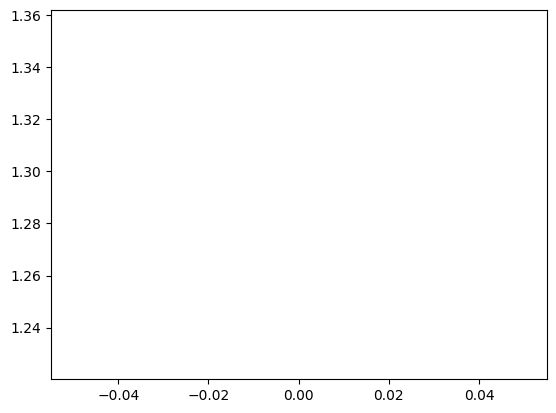

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='ResNet Loss', linestyle='-', marker='o', color='blue')
plt.plot(val_losses, label='ResNet Validation Loss', linestyle='-', marker='o', color='red')
plt.show()

## Testing the Model

In [ ]:
import tarfile
my_tar = tarfile.open("drive/MyDrive/test_set.tar")
my_tar.extractall("test_set")
my_tar.close()

In [ ]:
# Dataset preparation and pre-processing
# Add data augmentation
test_dataset = AffectDataset("test_set/val_set", transform_train)
test_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:

def predict_image(image_path, landmarks_path, model, device, transform):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Landmarks are needed to make a prediction
    # Replace this with actual landmarks from your dataset or acquired by other means
    landmarks = np.load(landmarks_path)
   
    landmarks = torch.tensor(landmarks, dtype=torch.float32).to(device)
    landmarks = landmarks.reshape(1, -1)
    # Make the prediction
    model.eval()
    with torch.no_grad():
        arousal_valence_preds, expression_preds = model(image_tensor, landmarks)

    arousal_valence = arousal_valence_preds.cpu().numpy()
    expression = torch.argmax(expression_preds, dim=1).cpu().numpy()

    return arousal_valence, expression

# Usage example
image_path = "test_set/val_set/images/184.jpg"
landmarks_path = "test_set/val_set/annotations/184_lnd.npy"
# model = model.to(device)
arousal_valence, emotions = predict_image(image_path, landmarks_path, model, device, transform_train)
emotion_dict = {0: "Neutral", 1: "Happy", 2: "Sad", 3: "Surprise", 4:
"Fear", 5: "Disgust", 6: "Anger", 7: 'Contempt'}

print("Predicted_traits:")

print("emotion = ", emotion_dict[emotions.item()])
print("Arousal = ", arousal_valence[0][0])
print("Valence = ", arousal_valence[0][1])

Predicted_traits:
emotion =  Neutral
Arousal =  0.14186443
Valence =  -0.22131512


In [ ]:
model_path = "resnet_back.pth"
torch.save(model.state_dict(), model_path)

## Training the other model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel(model_name="densenet121").to(device)

# Fine-tuning the model
# for param in model.resnet.parameters():
#     param.requires_grad = False

# num_ftrs = model.resnet.fc.in_features
# model.resnet.fc = nn.Linear(num_ftrs, 512)

# Define the optimizer and learning rate scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 85.2MB/s]


In [ ]:
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for i, (images, landmarks, arousal_valence_labels, expression_labels) in loop:
        
        images = images.to(device)
        landmarks = landmarks.to(device)
        arousal_valence_labels = arousal_valence_labels.to(device)
        expression_labels = expression_labels.to(device)

        # rest of the code

        optimizer.zero_grad()

        arousal_valence_preds, expression_preds = model(images, landmarks)
        loss1 = criterion1(arousal_valence_preds, arousal_valence_labels)
        loss2 = criterion2(expression_preds, expression_labels)
        loss = loss1 + loss2

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=running_loss / (i + 1))

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    running_val_loss = 0.0
    val_loop = tqdm(enumerate(val_loader), total=len(val_loader), leave=True)
    with torch.no_grad():
        for i, (images, landmarks, arousal_valence_labels, expression_labels) in val_loop:
            images = images.to(device)
            landmarks = landmarks.to(device)
            arousal_valence_labels = arousal_valence_labels.to(device)
            expression_labels = expression_labels.to(device)

            arousal_valence_preds, expression_preds = model(images, landmarks)
            val_loss1 = criterion1(arousal_valence_preds, arousal_valence_labels)
            val_loss2 = criterion2(expression_preds, expression_labels)
            val_loss = val_loss1 + val_loss2

            running_val_loss += val_loss.item()
            val_loop.set_description(f"Validation Epoch [{epoch+1}/{num_epochs}]")
            val_loop.set_postfix(val_loss=running_val_loss / (i + 1))

    val_losses.append(running_val_loss / len(val_loader))

    # Update the learning rate using the scheduler
    scheduler.step()


Validation Epoch [1/1]: 100%|██████████| 1798/1798 [11:18<00:00,  2.65it/s, val_loss=0.771]


In [ ]:
plt.plot(train_losses, label='ResNet Loss', linestyle='-', marker='o', color='blue')
plt.plot(val_losses, label='ResNet Validation Loss', linestyle='-', marker='o', color='red')
plt.show()

In [ ]:
model.eval()
# Usage example
image_path = "test_set/val_set/images/182.jpg"
landmarks_path = "test_set/val_set/annotations/182_lnd.npy"
# model = model.to(device)
arousal_valence, emotions = predict_image(image_path, landmarks_path, model, device, transform_train)
emotion_dict = {0: "Neutral", 1: "Happy", 2: "Sad", 3: "Surprise", 4:
"Fear", 5: "Disgust", 6: "Anger", 7: 'Contempt'}

print("Predicted_traits:")

print("emotion = ", emotion_dict[emotions.item()])
print("Arousal = ", arousal_valence[0][0])
print("Valence = ", arousal_valence[0][1])

print("Real Emotion:", emotion_dict[int(np.load("test_set/val_set/annotations/184_exp.npy").item())])
print("Real Arousal:", np.load("test_set/val_set/annotations/184_aro.npy"))
print("Real Valence:", np.load("test_set/val_set/annotations/184_val.npy"))

Predicted_traits:
emotion =  Anger
Arousal =  0.62899756
Valence =  0.06207083
Real Emotion: Neutral
Real Arousal: -0.200169
Real Valence: 0.200169


In [ ]:
model_path = "densenet_back.pth"
torch.save(model.state_dict(), model_path)